# Demo - White Box Attack (Imagenet)

In [1]:
import numpy as np
import json
import os
import sys
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    
# Using normalization for Inception v3.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],                     
#                          std=[0.229, 0.224, 0.225])
    
# However, DO NOT USE normalization transforms in this section.
# torchattacks only supports images with a range between 0 and 1.
# Thus, please refer to the model construction section.
    
])

## 1. Load Data

In [6]:
imagnet_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


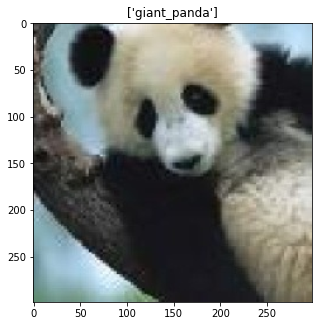

In [7]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

## 2. Load Inception v3

In [8]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [9]:
# Adding a normalization layer for Inception v3.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.inception_v3(pretrained=True)
).to(device)

model = model.eval()

## 3. Adversarial Attack (Original Mode)

In [10]:
atks = [torchattacks.FGSM(model, eps=8/255),
        torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=7),
        torchattacks.CW(model, c=1, kappa=0, steps=1000, lr=0.01),
        torchattacks.RFGSM(model, eps=8/255, alpha=4/255, steps=1),
        torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=7),
        torchattacks.FFGSM(model, eps=8/255, alpha=12/255),
        torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=7),
        torchattacks.MIFGSM(model, eps=8/255, decay=1.0, steps=5),
       ]

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


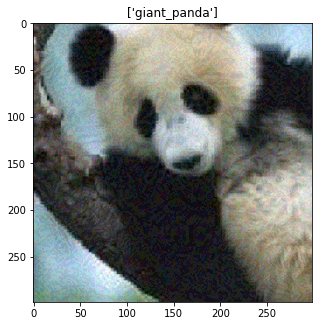

Total elapsed time (sec) : 1.28
Robust accuracy: 100.00 %
----------------------------------------------------------------------
BIM(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=7, attack_mode=default, return_type=float)


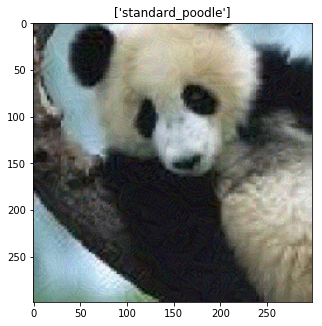

Total elapsed time (sec) : 0.60
Robust accuracy: 0.00 %
----------------------------------------------------------------------
CW(model_name=Sequential, training=False, device=cuda:0, c=1, kappa=0, steps=1000, lr=0.01, attack_mode=default, return_type=float)


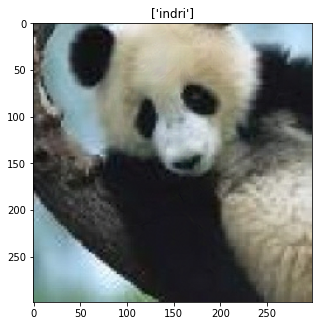

Total elapsed time (sec) : 24.76
Robust accuracy: 0.00 %
----------------------------------------------------------------------
RFGSM(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, alpha=0.01568627450980392, steps=1, attack_mode=default, return_type=float)


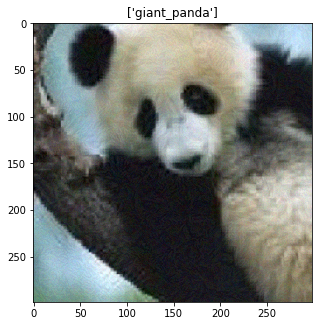

Total elapsed time (sec) : 0.25
Robust accuracy: 100.00 %
----------------------------------------------------------------------
PGD(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=7, random_start=False, attack_mode=default, return_type=float)


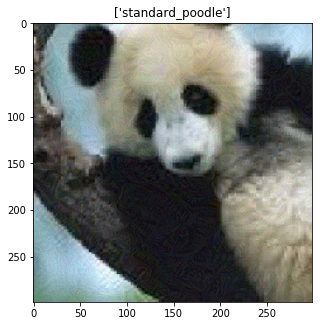

Total elapsed time (sec) : 0.59
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FFGSM(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, alpha=0.047058823529411764, attack_mode=default, return_type=float)


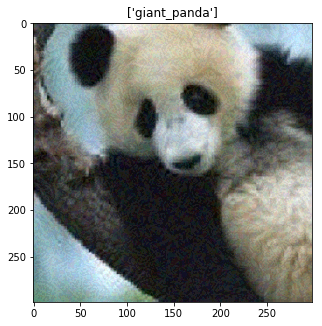

Total elapsed time (sec) : 0.26
Robust accuracy: 100.00 %
----------------------------------------------------------------------
TPGD(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=7, attack_mode=default, return_type=float)


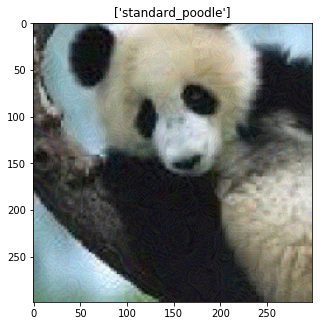

Total elapsed time (sec) : 0.65
Robust accuracy: 0.00 %
----------------------------------------------------------------------
MIFGSM(model_name=Sequential, training=False, device=cuda:0, eps=0.03137254901960784, steps=5, decay=1.0, alpha=0.006274509803921568, attack_mode=default, return_type=float)


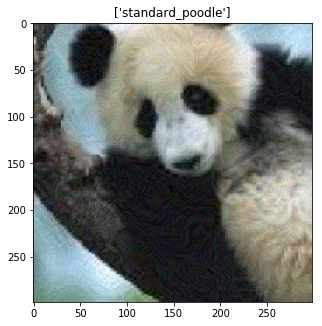

Total elapsed time (sec) : 0.51
Robust accuracy: 0.00 %


In [11]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        
        start = time.time()
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

    print('Total elapsed time (sec) : %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

## 4. Adversarial Attack (Targeted Mode)

In [12]:
atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)

In [13]:
target_map_function = lambda images, labels: labels.fill_(300)
# atk.set_attack_mode("targeted", target_map_function=target_map_function)
# or
atk.set_targeted_mode(target_map_function=target_map_function)

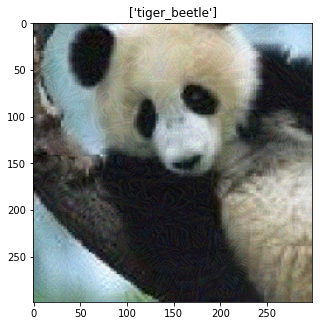

In [14]:
for images, labels in data_loader:

    # imagnet_data.classes[300] = 'tiger_beetle'    
    adv_images = atk(images, labels)
    labels = labels.to(device)
    outputs = model(adv_images)

    _, pre = torch.max(outputs.data, 1)

    imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

## 5. Adversarial Attack (Least Likely Mode)

In [15]:
atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)

In [16]:
# Least Likely Label
outputs = model(images.cuda())
_, pre = torch.min(outputs.data, 1)
print("Least Likely Label:", [imagnet_data.classes[i] for i in pre])

Least Likely Label: ['Lhasa']


In [17]:
# atk.set_attack_mode("least_likely")
# or
atk.set_least_likely_mode(kth_min=1)

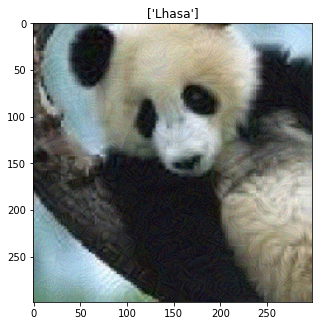

In [19]:
for images, labels in data_loader:
    
    adv_images = atk(images, labels) # input labels will be ignored in least likely mode.
    labels = labels.to(device)
    outputs = model(adv_images)

    _, pre = torch.max(outputs.data, 1)

    imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])